In [1]:
 %load_ext autoreload
 %autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from typing import Literal, Optional, List
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage
from langchain_core.messages import SystemMessage

from utils import show_graph
from prompts import BASE_PROMPT, PATIENT_INFO_ASKING_PROMPT, PATIENT_INFO_EXTRACTION_PROMPT

class PatientInfoPartial(BaseModel):
    name: Optional[str] = Field(description="The name of the patient")
    age: Optional[int] = Field(description="The age of the patient")
    sex: Optional[Literal["M", "F"]] = Field(description="The biological sex of the patient")

class SymptomsPartial(BaseModel):
    main_symptoms: Optional[list[str]] = Field(description="Primary symptom(s) patient is experiencing")
    symptom_onset: Optional[str] = Field(description="When symptoms started (e.g., '3 days ago', 'this morning')")
    associated_symptoms: Optional[list[str]] = Field(description="Related or secondary symptoms")
    additional_symptom_info: Optional[list[str]] = Field(description="Other relevant details: severity, triggers, alleviating factors etc.")

class SymptomSufficiencyCheck(BaseModel):
    is_sufficient: bool = Field(description="Whether the information provided is sufficient for first assessment by doctor")
    reason: Optional[str] = Field(description="Why more info is needed, or None if sufficient")

class MedHistoryFact(BaseModel):
    category: Literal["allergy","medication","past_condition","surgery",
                      "family_history","social","immunization","obgyn","other"]
    question: str = Field(description="Question for medical/health history. Eg. (Do you have diabetes?)")
    answer: str
    additional_details: Optional[str] = None

class MedHistorySufficiencyCheck(BaseModel):
    is_sufficient: bool
    reason: Optional[str] = None

class TriageSummary(BaseModel):
    probable_diagnosis: str = Field(description="The likely diagnosis for the patient based on the conversation and medical history.")
    reason_for_diagnosis: str = Field(description="The reason for the diagnosis, based on the conversation and medical history.")
    urgency: Literal["EMERGENCY", "URGENT", "SEMI-URGENT", "NON-URGENT"]
    reason_for_urgency: str = Field(description="The reason for the urgency of the diagnosis, based on the conversation and medical history.")
  

class AgentState(MessagesState):
    """State for the chatbot"""
    patient_name: str
    patient_age: int
    patient_sex: Literal["M", "F"]
    main_symptoms: list[str]
    symptom_onset: str
    associated_symptoms: list[str]
    additional_symptom_info: list[str]
    medical_history: List[MedHistoryFact]
    generated_summary: TriageSummary


In [4]:
# Phase 1: Patient Information Collection
llm = init_chat_model(model="gpt-4.1", temperature=0)
extract_llm = llm.with_structured_output(PatientInfoPartial)

def ask_patient_info(state: AgentState) -> AgentState: 
    print("Asking patient info")
    missing = []
    if state.get("patient_name") is None: missing.append("name")
    if state.get("patient_age") is None: missing.append("age")
    if state.get("patient_sex") is None: missing.append("sex")

    known_bits = []
    if state.get("patient_name") is not None: known_bits.append(f"name={state['patient_name']}")
    if state.get("patient_age") is not None: known_bits.append(f"age={state['patient_age']}")
    if state.get("patient_sex") is not None: known_bits.append(f"sex={state['patient_sex']}")

    steering = (
        "You are collecting basic patient demographic information for triage.\n"
        f"Known so far: {', '.join(known_bits) if known_bits else 'none'}.\n"
        f"Missing (in order): {', '.join(missing) if missing else 'none'}.\n"
        "- If anything is missing, ask ONLY for the first missing field with one concise question.\n"
        "- Keep it friendly and brief."
    )

    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=PATIENT_INFO_ASKING_PROMPT),
        SystemMessage(content=steering),
        *state["messages"],
    ]
    resp = llm.invoke(msgs)

    return {"messages": [resp]}

def extract_patient_info(state: AgentState) -> AgentState:
    print("Extracting patient info")
    human_only = [m for m in state.get("messages", []) if isinstance(m, HumanMessage)]
    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=(
            PATIENT_INFO_EXTRACTION_PROMPT +
            "\nOnly extract info stated by the patient. If not present, leave that field null. Use the right capitalization for names (eg. Jon Ang instead of jon ang)."
        )),
        *human_only,
    ]
    parsed: PatientInfoPartial = extract_llm.invoke(msgs)

    updates = {}
    if parsed.name is not None and state.get("patient_name") is None:
        updates["patient_name"] = parsed.name.upper()
    if parsed.age is not None and state.get("patient_age") is None:
        updates["patient_age"] = parsed.age
    if parsed.sex is not None and state.get("patient_sex") is None:
        updates["patient_sex"] = parsed.sex
    return updates


patient_demo_builder = StateGraph(AgentState)
patient_demo_builder.add_node("collect_patient_info", extract_patient_info)
patient_demo_builder.add_node("ask_patient_info", ask_patient_info)

patient_demo_builder.add_edge(START, "ask_patient_info")
patient_demo_builder.add_edge("ask_patient_info", "collect_patient_info")
patient_demo_builder.add_edge("collect_patient_info", END)

patient_demo_graph = patient_demo_builder.compile()


In [9]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
patient_demo_graph = patient_demo_builder.compile(checkpointer=checkpointer)

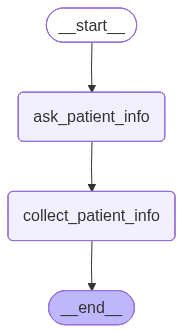

In [48]:
show_graph(patient_demo_graph)

In [49]:
from langchain_core.messages import HumanMessage, AIMessage

state = {
    "messages": [],
    "patient_name": None,
    "patient_age": None,
    "patient_sex": None,
}

config = {"configurable": {"thread_id": "1"}}

last_ai_key = None 

# Initial invoke
for event in patient_demo_graph.stream({"messages": []}, config, stream_mode="values"):
    msgs = event.get("messages", [])
    if not msgs:
        continue
    last = msgs[-1]
    if isinstance(last, AIMessage):
        key = getattr(last, "id", None) or (last.content, len(msgs))
        if key != last_ai_key:
            print("Assistant:", last.content)
            last_ai_key = key

def is_complete(state: dict) -> bool:
    return state.get("patient_name") is not None and state.get("patient_age") is not None and state.get("patient_sex") is not None

# Loop
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    
    for event in patient_demo_graph.stream({"messages": [HumanMessage(content=user_input)]}, config, stream_mode="values"):
        msgs = event.get("messages", [])
        if not msgs:
            continue
        last = msgs[-1]
        if isinstance(last, AIMessage):
            key = getattr(last, "id", None) or (last.content, len(msgs))
            if key != last_ai_key:
                print("Assistant:", last.content)
                last_ai_key = key
    
    # Check state
    snapshot = patient_demo_graph.get_state(config)
    if is_complete(snapshot.values):
        s = snapshot.values
        print(f"\n✓ Complete! Name: {s['patient_name']}, Age: {s['patient_age']}, Sex: {s['patient_sex']}")
        break

checkpointer.delete_thread("1")

Asking patient info
Assistant: Hi, welcome to ClinicAssist. How can I help you today? To get started, may I have your name, please?
Extracting patient info
Asking patient info
Assistant: Thank you, Wang Junwei. Could you please tell me your age?
Extracting patient info
Asking patient info
Assistant: Thank you. Could you please let me know your sex (male, female, or other)?
Extracting patient info
Asking patient info
Assistant: Thank you for providing your information. 

Now, let's move on to your symptoms. Could you please describe the main reason for your visit or any symptoms you are experiencing today?
Extracting patient info

✓ Complete! Name: wang junwei, Age: 23, Sex: M


In [5]:
from prompts import BASE_PROMPT, SYMPTOMS_ASKING_PROMPT, SYMPTOMS_EXTRACTION_PROMPT, SYMPTOMS_SUFFICIENCY_CHECK_PROMPT
from datetime import datetime

def get_current_time():
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Phase 2: Symptoms Collection

symptoms_llm = llm.with_structured_output(SymptomsPartial)
symptom_sufficiency_llm = llm.with_structured_output(SymptomSufficiencyCheck)

def ask_symptoms(state: AgentState) -> AgentState:
    print("Asking symptoms")
    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=SYMPTOMS_ASKING_PROMPT.format(current_time=get_current_time())),
        *state["messages"],
    ]
    resp = llm.invoke(msgs)
    return {"messages": [resp]}

def extract_symptoms(state: AgentState) -> AgentState:
    print("Extracting symptoms")
    # Get current state to pass as context
    extracted_symptoms = {
        "main_symptoms": state.get("main_symptoms") or [],
        "symptom_onset": state.get("symptom_onset"),
        "associated_symptoms": state.get("associated_symptoms") or [],
        "additional_symptom_info": state.get("additional_symptom_info") or []
    }
    
    # Get ALL messages for context
    all_messages = state.get("messages", [])
    
    # Get only RECENT messages (e.g., last 2 messages)
    # This prevents re-extracting old info while maintaining context
    recent_messages = all_messages[-4:] if len(all_messages) > 1 else all_messages
    
    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=(
            SYMPTOMS_EXTRACTION_PROMPT.format(
                current_time=get_current_time(), 
                extracted_symptoms=extracted_symptoms
            ) +
            "\nOnly extract NEW info from the patient's most recent message(s). "
            "Do not re-extract information already in extracted_symptoms above."
        )),
        *recent_messages,  # All recent messages
    ]
    
    parsed: SymptomsPartial = symptoms_llm.invoke(msgs)
    updates = {}
    
    # MAIN SYMPTOMS - merge lists with deduplication
    if parsed.main_symptoms is not None and len(parsed.main_symptoms) > 0:
        existing = state.get("main_symptoms") or []
        # Normalize and deduplicate (case-insensitive)
        existing_lower = [s.lower() for s in existing]
        new_symptoms = [
            s for s in parsed.main_symptoms 
            if s.lower() not in existing_lower
        ]
        if new_symptoms:
            updates["main_symptoms"] = existing + new_symptoms
    
    # ONSET - allow updates (corrections)
    if parsed.symptom_onset is not None:
        existing = state.get("symptom_onset") or []
        if parsed.symptom_onset not in existing:
            updates["symptom_onset"] = parsed.symptom_onset
    
    # ASSOCIATED SYMPTOMS - merge with deduplication
    if parsed.associated_symptoms is not None and len(parsed.associated_symptoms) > 0:
        existing = state.get("associated_symptoms") or []
        existing_lower = [s.lower() for s in existing]
        new_associated = [
            s for s in parsed.associated_symptoms 
            if s.lower() not in existing_lower
        ]
        if new_associated:
            updates["associated_symptoms"] = existing + new_associated
    
    # ADDITIONAL INFO - append new info (don't deduplicate as details may vary)
    if parsed.additional_symptom_info is not None and len(parsed.additional_symptom_info) > 0:
        existing = state.get("additional_symptom_info") or []
        # For additional info, we append (may have related but different details)
        updates["additional_symptom_info"] = existing + parsed.additional_symptom_info
    
    print("Extracted symptoms: ", updates)
    
    return updates

def check_symptom_sufficiency(dict: dict):
    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=SYMPTOMS_SUFFICIENCY_CHECK_PROMPT),
        *dict["messages"],
    ]
    resp = symptom_sufficiency_llm.invoke(msgs)
    
    return resp

def should_continue(dict: dict):
    has_main = dict.get("main_symptoms") and len(dict["main_symptoms"]) > 0
    has_onset = dict.get("symptom_onset") is not None

    if not (has_main and has_onset):
        return False
    
    check = check_symptom_sufficiency(dict)
    return check.is_sufficient

symptoms_builder = StateGraph(AgentState)
symptoms_builder.add_node("ask_symptoms", ask_symptoms)
symptoms_builder.add_node("extract_symptoms", extract_symptoms)

symptoms_builder.add_edge(START, "ask_symptoms")
symptoms_builder.add_edge("ask_symptoms", "extract_symptoms")
symptoms_builder.add_edge("extract_symptoms", END)

symptoms_graph = symptoms_builder.compile()

In [51]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
symptoms_graph = symptoms_builder.compile(checkpointer=checkpointer)

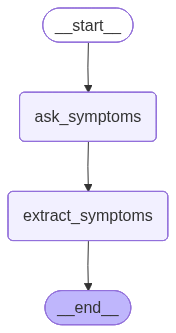

In [52]:
show_graph(symptoms_graph)

In [39]:
from langchain_core.messages import HumanMessage, AIMessage

config = {"configurable": {"thread_id": "1"}}

last_ai_key = None 

# Initial invoke
for event in symptoms_graph.stream({"messages": []}, config, stream_mode="values"):
    msgs = event.get("messages", [])
    if not msgs:
        continue
    last = msgs[-1]
    if isinstance(last, AIMessage):
        key = getattr(last, "id", None) or (last.content, len(msgs))
        if key != last_ai_key:
            print("Assistant:", last.content)
            last_ai_key = key

# Loop
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    
    for event in symptoms_graph.stream({"messages": [HumanMessage(content=user_input)]}, config, stream_mode="values"):
        msgs = event.get("messages", [])
        if not msgs:
            continue
        last = msgs[-1]
        if isinstance(last, AIMessage):
            key = getattr(last, "id", None) or (last.content, len(msgs))
            if key != last_ai_key:
                print("Assistant:", last.content)
                last_ai_key = key
    
    # Check state
    snapshot = symptoms_graph.get_state(config)
    if should_continue(snapshot.values):
        s = snapshot.values
        print(f"\n✓ Complete! Main Symptoms: {s['main_symptoms']}\n Symptom Onset: {s['symptom_onset']}\n Associated Symptoms: {s['associated_symptoms']}\n Additional Symptom Info: {s['additional_symptom_info']}")
        break

checkpointer.delete_thread("1")

Assistant: Thank you for providing your demographic information. Now, I'd like to learn more about the symptoms that brought you to the clinic today. 

Can you please describe the main symptom or problem you are experiencing right now?
Extracted symptoms:  {}
Assistant: Thank you for sharing that. How long have you been experiencing the fever and headache?
Extracted symptoms:  {'main_symptoms': ['fever', 'headache']}
Assistant: Thank you for clarifying. Can you tell me how high your fever has been, if you've measured it? And is your headache mild, moderate, or severe?
Extracted symptoms:  {'symptom_onset': 'fever since the morning and headache since noon'}
Assistant: Thank you for that information. Have you noticed any other symptoms, such as a sore throat, cough, runny nose, body aches, nausea, vomiting, or any other changes?
Extracted symptoms:  {'additional_symptom_info': ['Fever measured to be around 38.2 degrees', 'Headache is moderate in severity']}
Assistant: Thank you for letti

KeyError: 'associated_symptoms'

In [6]:
# Phase 3: Health and Medical History Collection
from prompts import MEDICAL_HISTORY_EXTRACTION_PROMPT, MEDICAL_HISTORY_ASKING_PROMPT, MEDICAL_HISTORY_SUFFICIENCY_CHECK_PROMPT

medhist_llm = llm.with_structured_output(MedHistoryFact)
medhist_sufficiency_llm = llm.with_structured_output(MedHistorySufficiencyCheck)

def format_medhist_facts(facts: List[MedHistoryFact]) -> str:
    return "\n".join([f"{fact.category}: {fact.question} - {fact.answer} {f'({fact.additional_details})' if fact.additional_details else ''}" for fact in facts])

def extract_medhist(state: AgentState) -> AgentState:
    print("Extracting medical history")
    existing_facts = state.get("medical_history", [])

    facts_summary = format_medhist_facts(existing_facts)
    recent_messages = state.get("messages", [])[-4:]

    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=MEDICAL_HISTORY_EXTRACTION_PROMPT.format(
            current_time=get_current_time(),
            extracted_patient_info={
                "name": state["patient_name"],
                "age": state["patient_age"],
                "sex": state["patient_sex"]
            },
            extracted_symptoms={
                "main_symptoms": state["main_symptoms"],
                "symptom_onset": state["symptom_onset"],
                "associated_symptoms": state["associated_symptoms"],
                "additional_symptom_info": state["additional_symptom_info"]
            },
            extracted_medical_history=facts_summary
        )),
        *recent_messages,
    ]

    parsed = medhist_llm.invoke(msgs)
    updates = {}
    if parsed.category is not None and parsed.question is not None and parsed.answer is not None:
        updates["medical_history"] = existing_facts + [parsed]
    
    return updates

def ask_medhist(state: AgentState) -> AgentState:
    print("Asking medical history")
    existing_facts = state.get("medical_history", [])

    facts_summary = format_medhist_facts(existing_facts)

    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=MEDICAL_HISTORY_ASKING_PROMPT.format(
            current_time=get_current_time(),
            extracted_patient_info={
                "name": state["patient_name"],
                "age": state["patient_age"],
                "sex": state["patient_sex"]
            },
            extracted_symptoms={
                "main_symptoms": state["main_symptoms"],
                "symptom_onset": state["symptom_onset"],
                "associated_symptoms": state["associated_symptoms"],
                "additional_symptom_info": state["additional_symptom_info"]
            },
            extracted_medical_history=facts_summary
        ))
    ]

    resp = llm.invoke(msgs)
    return {"messages": [resp]}

def route_after_med_history(state):
    facts = state.get("medical_history_facts", [])
    
    # Check mandatory items
    # has_past_condition_info = any(f.category == "past_condition" for f in facts)
    # has_medication_info = any(f.category == "medication" for f in facts)
    
    # if not (has_past_condition_info and has_medication_info):
    #     return "ask_medhist"  # Keep asking
    
    # LLM sufficiency check for everything else
    check = check_medhist_sufficiency(state)
    return "triage_summary" if check.is_sufficient else "ask_medhist"

def check_medhist_sufficiency(state):
    print("Checking medical history sufficiency")
    facts = state.get("medical_history_facts", [])
    
    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=MEDICAL_HISTORY_SUFFICIENCY_CHECK_PROMPT.format(
            extracted_medical_history=format_medhist_facts(facts)
        )),
        *state["messages"],
    ]

    resp = medhist_sufficiency_llm.invoke(msgs)
    print(resp)
    return resp

In [7]:
from prompts import TRIAGE_SUMMARY_PROMPT, ACKNOWLEDGEMENT_PROMPT
  
final_llm = llm.with_structured_output(TriageSummary)

def triage_summary(state: AgentState) -> AgentState:
    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=TRIAGE_SUMMARY_PROMPT),
        *state["messages"],
    ]
    parsed = final_llm.invoke(msgs)
    return {"generated_summary": parsed}

def acknowledgement(state: AgentState) -> AgentState:
    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=ACKNOWLEDGEMENT_PROMPT),
        *state["messages"],
    ]
    resp = llm.invoke(msgs)
    return {"messages": [resp]}

In [10]:
# Cell for unified graph
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command

# Use all your existing node functions
# ask_patient_info, extract_patient_info (Phase 1)
# ask_symptoms, extract_symptoms (Phase 2)

# Conditional routing functions
def route_after_patient_info(state: AgentState) -> str:
    """Check if Phase 1 is complete, route to Phase 2 or loop back"""
    has_name = state.get("patient_name") is not None
    has_age = state.get("patient_age") is not None
    has_sex = state.get("patient_sex") is not None
    
    if has_name and has_age and has_sex:
        # Phase 1 complete → move to Phase 2
        return "ask_symptoms"
    else:
        # Phase 1 incomplete → loop back
        return "ask_patient_info"

def route_after_symptoms(state: AgentState) -> str:
    """Check if Phase 2 is complete, route to Phase 3 or loop back"""
    has_main = state.get("main_symptoms") and len(state["main_symptoms"]) > 0
    has_onset = state.get("symptom_onset") is not None
    
    if not (has_main and has_onset):
        # Missing core fields → keep asking
        return "ask_symptoms"
    
    # Check LLM sufficiency assessment
    check = check_symptom_sufficiency(state)
    
    if check.is_sufficient:
        # Phase 2 complete → move to ask_medhist 
        return "ask_medhist"
    else:
        # Need more details → loop back
        return "ask_symptoms"

def human_patient_info_node(state: AgentState) -> AgentState:
    user_input = interrupt("Waiting for patient info")
    return {"messages": [HumanMessage(content=user_input)]}


def human_symptoms_node(state: AgentState) -> AgentState:
    user_input = interrupt("Waiting for symptoms")
    return {"messages": [HumanMessage(content=user_input)]}

def human_medhist_node(state: AgentState) -> AgentState:
    user_input = interrupt("Waiting for medical history")
    return {"messages": [HumanMessage(content=user_input)]}


# Build unified graph
clinical_assistant_builder = StateGraph(AgentState)

# Add Phase 1 nodes
clinical_assistant_builder.add_node("ask_patient_info", ask_patient_info)
clinical_assistant_builder.add_node("extract_patient_info", extract_patient_info)
clinical_assistant_builder.add_node("human_patient_info_node", human_patient_info_node)

# Add Phase 2 nodes
clinical_assistant_builder.add_node("ask_symptoms", ask_symptoms)
clinical_assistant_builder.add_node("extract_symptoms", extract_symptoms)
clinical_assistant_builder.add_node("human_symptoms_node", human_symptoms_node)

# Add Phase 3 nodes
clinical_assistant_builder.add_node("ask_medhist", ask_medhist)
clinical_assistant_builder.add_node("extract_medhist", extract_medhist)
clinical_assistant_builder.add_node("human_medhist_node", human_medhist_node)

# Add Phase 4 nodes
clinical_assistant_builder.add_node("triage_summary", triage_summary)
clinical_assistant_builder.add_node("acknowledgement", acknowledgement)

# Phase 1 flow
clinical_assistant_builder.add_edge(START, "ask_patient_info")
clinical_assistant_builder.add_edge("ask_patient_info", "human_patient_info_node")
clinical_assistant_builder.add_edge("human_patient_info_node", "extract_patient_info")

# Conditional edge: Phase 1 → Phase 2 or loop
clinical_assistant_builder.add_conditional_edges(
    "extract_patient_info",
    route_after_patient_info,
    {
        "ask_patient_info": "ask_patient_info",  # Loop back if incomplete
        "ask_symptoms": "ask_symptoms"           # Move to Phase 2 if complete
    }
)

# Phase 2 flow
clinical_assistant_builder.add_edge("ask_symptoms", "human_symptoms_node")
clinical_assistant_builder.add_edge("human_symptoms_node", "extract_symptoms")

# Conditional edge: Phase 2 → Phase 3 or loop
clinical_assistant_builder.add_conditional_edges(
    "extract_symptoms",
    route_after_symptoms,
    {
        "ask_symptoms": "ask_symptoms",  # Loop back if incomplete
        "ask_medhist": "ask_medhist"                         # End when complete (or Phase 3 later)
    }
)

# Phase 3 flow
clinical_assistant_builder.add_edge("ask_medhist", "human_medhist_node")
clinical_assistant_builder.add_edge("human_medhist_node", "extract_medhist")

# Phase 4 flow
clinical_assistant_builder.add_edge("triage_summary", "acknowledgement")
clinical_assistant_builder.add_edge("acknowledgement", END)

# Conditional edge: Phase 3 → END or loop
clinical_assistant_builder.add_conditional_edges(
    "extract_medhist",
    route_after_med_history,
    {
        "ask_medhist": "ask_medhist",  # Loop back if incomplete
        "triage_summary": "triage_summary"                         # End when complete (or Phase 3 later)
    }
)

# Compile
clinical_assistant_graph = clinical_assistant_builder.compile()

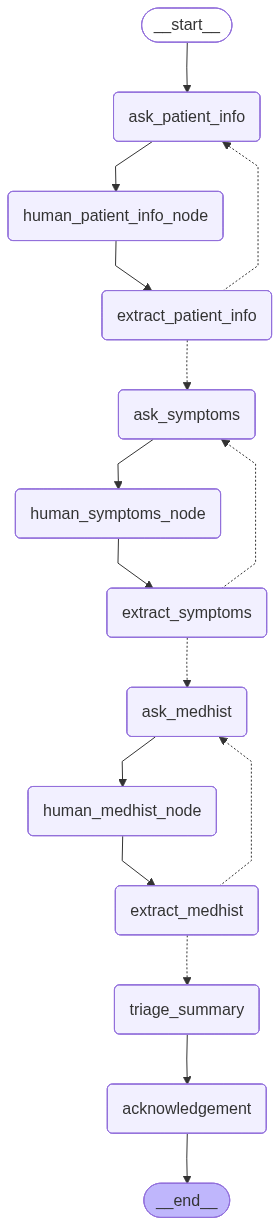

In [11]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

# Interrupt AFTER asking questions (so they're displayed)
clinical_assistant_graph = clinical_assistant_builder.compile(
    checkpointer=checkpointer,
    # interrupt_before=["human_patient_info_node", "human_symptoms_node"]
)

show_graph(clinical_assistant_graph)

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage

config = {"configurable": {"thread_id": "unified_1"}}
last_ai_key = None

def print_new_ai_messages(event):
    global last_ai_key
    msgs = event.get("messages", [])
    if not msgs:
        return
    last = msgs[-1]
    if isinstance(last, AIMessage):
        key = getattr(last, "id", None) or (last.content, len(msgs))
        if key != last_ai_key:
            print("Assistant:", last.content)
            last_ai_key = key

# Initial invoke - runs through ask_patient_info then pauses
for message, metadata in clinical_assistant_graph.stream({"messages": []}, config, stream_mode="messages"):
    if message.content and metadata.get("langgraph_node") in ["ask_patient_info", "ask_symptoms", "ask_medhist", "acknowledgement"]:
        print(message.content, end="", flush=True)
    # print_new_ai_messages(message, metadata)

# Main conversation loop
while True:
    
    # Wait for user input
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    
    # Resume with user message
    for message, metadata in clinical_assistant_graph.stream(
        Command(resume=user_input), 
        config, 
        stream_mode="messages"
    ):
        if message.content and metadata.get("langgraph_node") in ["ask_patient_info", "ask_symptoms", "ask_medhist", "acknowledgement"]:
            print(message.content, end="", flush=True)
        # print_new_ai_messages(event)
    print("")

    # Get current state
    snapshot = clinical_assistant_graph.get_state(config)
    
    # Check if complete (no next nodes)
    if not snapshot.next:
        s = snapshot.values
        print(f"\n✓ All phases complete!")
        print(f"Name: {s['patient_name']}, Age: {s['patient_age']}, Sex: {s['patient_sex']}")
        if 'main_symptoms' in s:
            print(f"Main Symptoms: {s['main_symptoms']}")
        if 'symptom_onset' in s:
            print(f"Symptom Onset: {s['symptom_onset']}")
        if 'associated_symptoms' in s:
            print(f"Associated Symptoms: {s['associated_symptoms']}")
        if 'additional_symptom_info' in s:
            print(f"Additional Symptom Info: {s['additional_symptom_info']}")
        if 'medical_history' in s:
            print(f"Medical History: {s['medical_history']}")
        if 'generated_summary' in s:
            print(f"Triage Summary: {s['generated_summary']}")
        break

checkpointer.delete_thread("unified_1")

Asking patient info
Hi, Welcome to ClinicAssist! To get started, may I have your name, please?Extracting patient info
Asking patient info
Thank you, Wang Junwei. Could you please tell me your age?

Extracting patient info
Asking patient info
Thank you! Could you please let me know your sex (male, female, or other)?

Goodbye!


In [86]:
snapshot.values


{'messages': [AIMessage(content='Hi, Welcome to ClinicAssist! To get started, may I have your name, please?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 199, 'total_tokens': 218, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_e24a1fec47', 'id': 'chatcmpl-CPsAGGmHXPdpgq0FZpxQUJhIWrnrl', 'finish_reason': 'stop', 'logprobs': None}, id='run-2533f4db-4abe-4516-a382-6304fd1b2c80-0', usage_metadata={'input_tokens': 199, 'output_tokens': 19, 'total_tokens': 218, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='wang junwei', additional_kwargs={}, response_metadata={}, id='8a48c92a-8cea-445d-8bc0-38a82994baae'),
  AIMessage(c